In [ ]:
import numpy as np
import pandas as pd 
import os

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from scipy.stats import skew, norm

%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv("Data/train.csv")
X = train_df.iloc[:, :-1]
y = train_df['SalePrice']

ntrain = X.shape[0]
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
X.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# 1) Data Observations & Visualizations

**Distribution of Sale Price**

In [94]:
print(y.describe())
sns.distplot(y, bins=100)

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

Some observations
- skewed positively
- has one peak
- deviate from normal distribution

**Distribution of Numerical Features**

In [ ]:
numeric_df = X.select_dtypes(include = ['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['Id'])

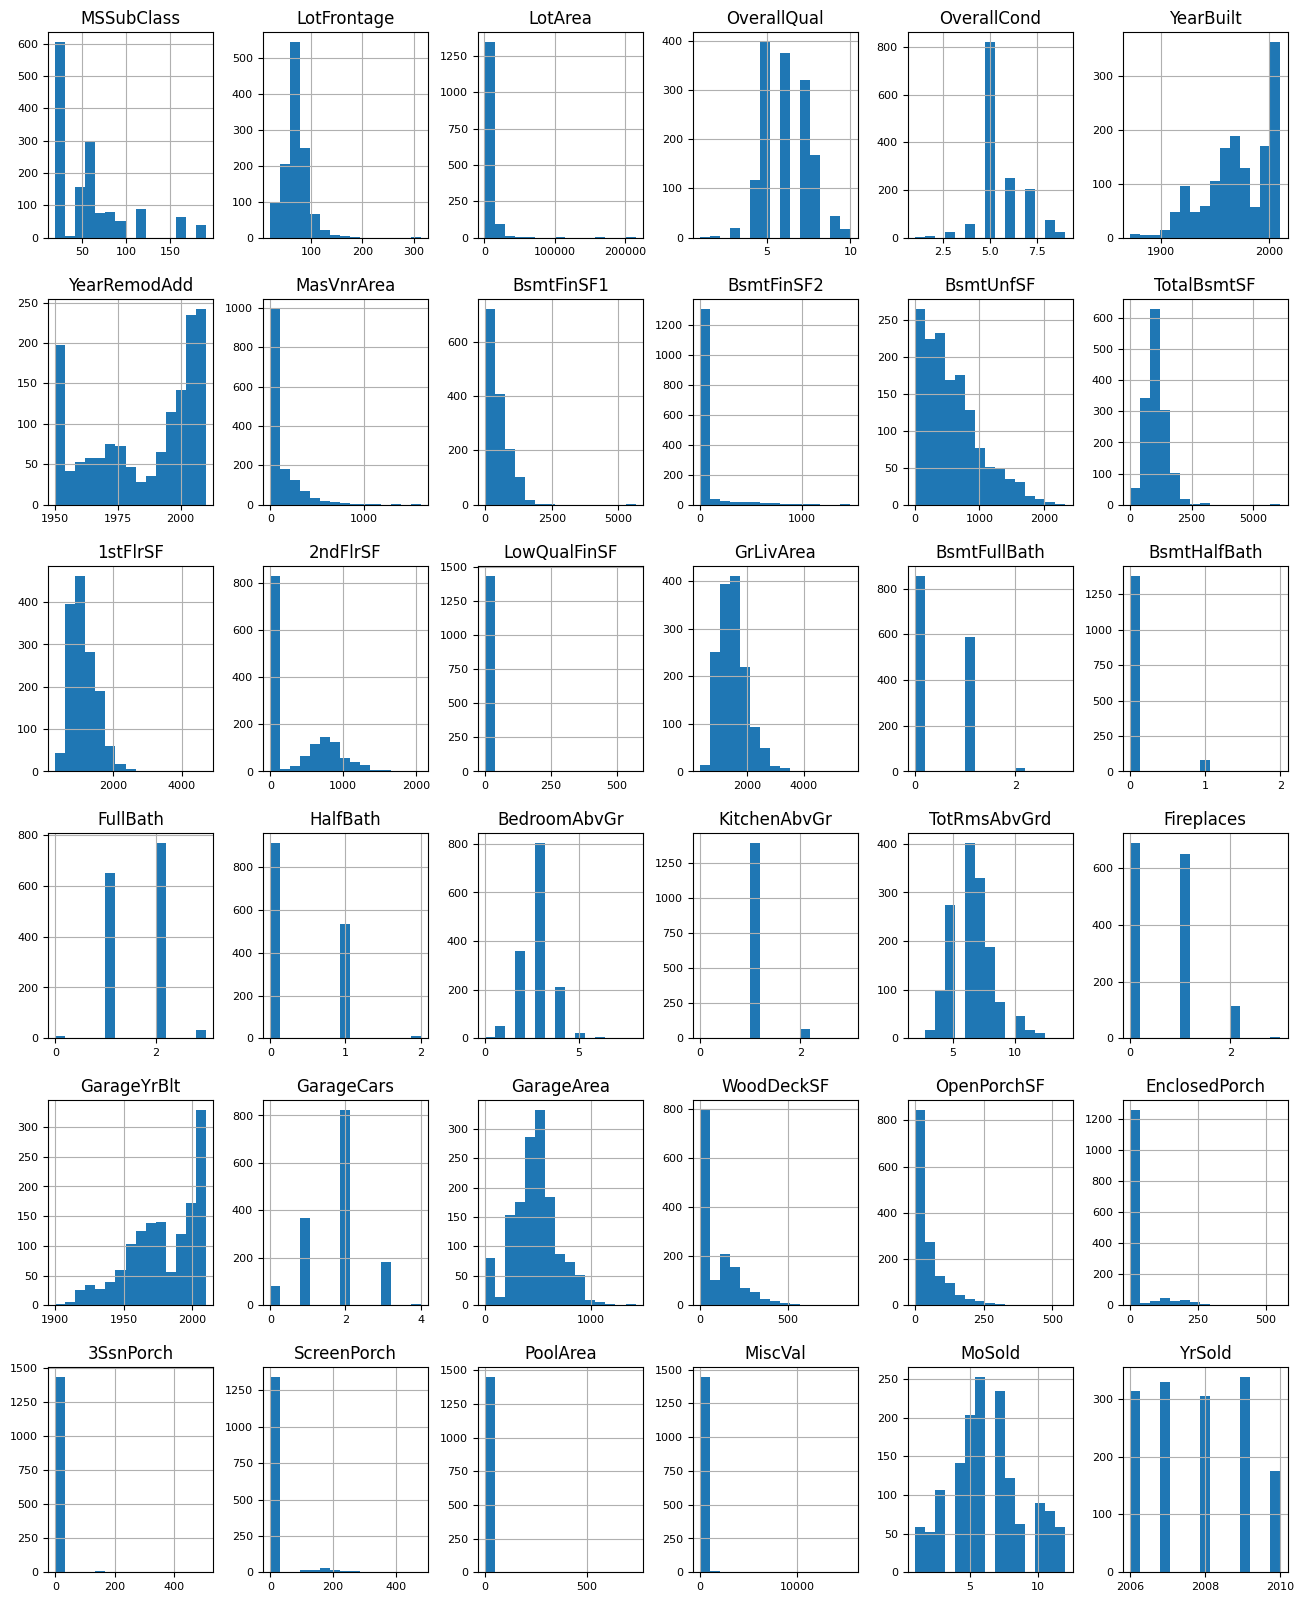

In [ ]:
hist = numeric_df.hist(figsize=(16,20), bins=15, xlabelsize=8, ylabelsize=8)

Pool area and variables related to porch has very low variability. 

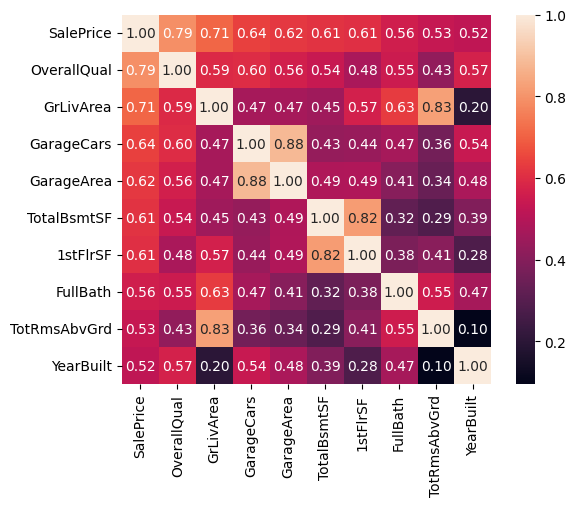

In [ ]:
# correlation matrix
k = 10
numeric_df = train_df.select_dtypes(include = ['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['Id'])
corr = numeric_df.corr()
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- GarageCars and GarageArea are strongly correlated. 
- TotalBsmtSF and 1stFlrSF are also strongly correlated.
- TotRmsAbvGrd and GrLivArea are also strongly correlated. 
- We can see strong positive correlation between GrLiveArea, OverallQual and SalePrice

**Visualization of Important Variables**

(-0.5, 9.5, 0.0, 800000.0)

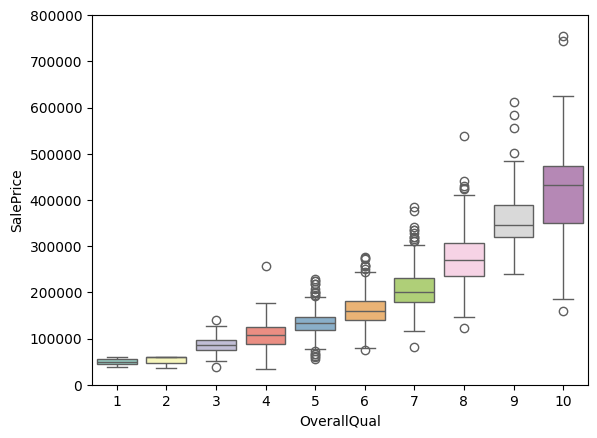

In [ ]:
# boxplot of OverallQual vs. SalePrice
data = pd.concat([y, train_df['OverallQual']], axis=1)
fig = sns.boxplot(x='OverallQual', y='SalePrice', data=data,  palette='Set3')
fig.axis(ymin=0, ymax=800000)

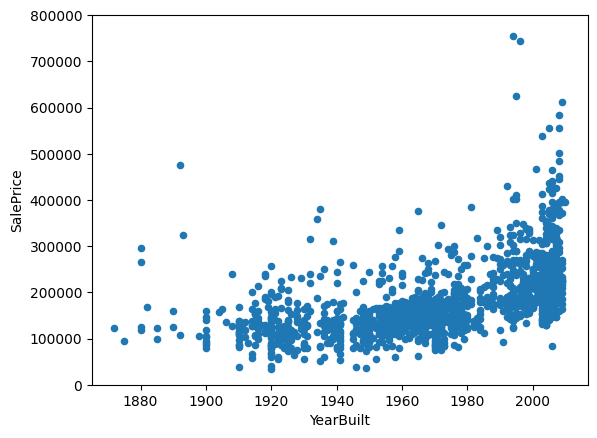

In [ ]:
#boxplot of YearBuilt vs. SalePrice
data = pd.concat([y, train_df['YearBuilt']], axis=1)
data.plot.scatter(x='YearBuilt', y='SalePrice', ylim=(0,800000))
plt.show()

(-0.5, 24.5, 0.0, 800000.0)

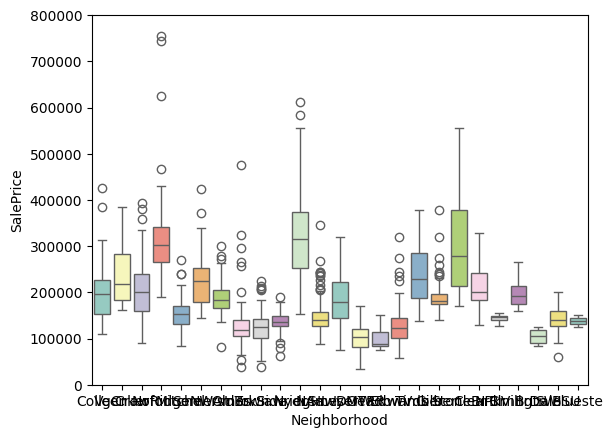

In [ ]:
data = pd.concat([y, train_df['Neighborhood']], axis=1)
fig = sns.boxplot(x='Neighborhood', y='SalePrice', data=data,  palette='Set3')
fig.axis(ymin=0, ymax=800000)

# 2) Data Manipulation

**Missing Data**

In [ ]:
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(19)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479


**Garage related variables**: all missing entries have GarageArea = 0.

In [ ]:
X[X['GarageYrBlt'].isnull()][['GarageArea']].describe()

,GarageArea
count,81.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


All entries with any missing garage related variables do not have a garage (GarageArea = 0). Therefore, we can fill the missing values with 'NA' (since they are categoric).

In [ ]:
garage_var = ['GarageCond', 'GarageFinish', 'GarageType', 'GarageQual','GarageArea', 'GarageYrBlt']

for col in garage_var:
    X[col]=X[col].fillna('NA') 

**Basement related variables**: most missing entries have TotalBsmtSF = 0.

In [ ]:
X[X['TotalBsmtSF']==0][['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','TotalBsmtSF']].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0
39,NaN,NaN,NaN,NaN,NaN,0
90,NaN,NaN,NaN,NaN,NaN,0
102,NaN,NaN,NaN,NaN,NaN,0
156,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
# since TotalBsmtSF=0, fill the categorical basement variables with NA
bsmt_var = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
for col in bsmt_var:
    X.loc[X['TotalBsmtSF']==0, col] = 'NA'

In [ ]:
missing_bs1 = X[X['BsmtExposure'].isnull()][['BsmtExposure','BsmtFinType2','TotalBsmtSF']]
missing_bs2 = X[X['BsmtFinType2'].isnull()][['BsmtExposure','BsmtFinType2','TotalBsmtSF']]
pd.concat((missing_bs1, missing_bs2))

,BsmtExposure,BsmtFinType2,TotalBsmtSF
948,NaN,Unf,936
332,No,NaN,3206


In [ ]:
for col in ['BsmtExposure','BsmtFinType2']:
    max_val = X.groupby(X[X['TotalBsmtSF']!=0][col])['Id'].count().idxmax()
    X[col] = X[col].fillna(max_val)
    print(f'{col}: {max_val}')

BsmtExposure: No
BsmtFinType2: Unf


**MiscFeature, Alley, Fence, FireplaceQu**: null values indicate that there isn't one. Therefore, we will fill the missing values with 'NA'.

In [ ]:
cols = ['MiscFeature','Alley', 'Fence','FireplaceQu']
for col in cols:
    X[col] = X[col].fillna('NA')

**MasVnrType, MasVnrArea**: most missing entries do not have masonry veneer (MasVnrArea = 0). 

In [ ]:
X[X['MasVnrType'].isna()][['Id']].describe()

,Id
count,872.000000
mean,740.263761
std,420.723235
min,2.000000
25%,384.750000
50%,746.000000
75%,1109.500000
max,1460.000000


In [ ]:
# entries where the area and type are both null, or area is not null but type is.
df1 = X[X['MasVnrType'].isnull() & X['MasVnrArea']!=0][['MasVnrType','MasVnrArea']]
df2 = X[X['MasVnrArea'].isnull()][['MasVnrType','MasVnrArea']]
pd.concat((df1,df2))

,MasVnrType,MasVnrArea
624,NaN,288.0
773,NaN,1.0
1230,NaN,1.0
1300,NaN,344.0
1334,NaN,312.0
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN


In [ ]:
X.groupby(X['MasVnrType'])['Id'].describe()

,count,mean,std,min,25%,50%,75%,max
MasVnrType,,,,,,,,
BrkCmn,15.0,563.466667,365.587564,84.0,262.00,511.0,734.00,1288.0
BrkFace,445.0,707.314607,415.313097,1.0,343.00,696.0,1044.00,1453.0
Stone,128.0,764.164062,450.984501,7.0,336.25,805.0,1166.25,1457.0


The entries where MasVnrArea = 1 is likely an error, so we will correct this to MasVnrArea = 0. The rest is filled with the most common type BrkFace. The rest of the values where MasVnrArea = 0 can be filled with MasVnrType = None.

In [ ]:
X.at[773,'MasVnrArea'] = 0
X.at[1230,'MasVnrArea'] = 0
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X.loc[[624, 1300, 1334], 'MasVnrType'] = 'BrkFace'
X['MasVnrType'] = X['MasVnrType'].fillna('None')

**Electrical**: Fill in the missing values of the following columns with the mode.

In [ ]:
for col in ['Electrical']:
    max_idx = X.groupby([col])['Id'].count().idxmax()
    print(f'{col}: {max_idx}')
    X[col] = X[col].fillna(max_idx)

Electrical: SBrkr


**LotFrontage**: group by neighborhoods and fill in with the median value

In [ ]:
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**PoolQC**: PoolQC is missing most data, so we will drop this column.

In [ ]:
X = X.drop(['PoolQC'], axis=1)

In [ ]:
# make sure that there are no missing data
X.isnull().sum().max()

0

**Outliers** Bivariate Analysis

Houses with larger GrLivArea (above ground living area) should have a higher price. Since this is one of the most correlated features with SalePrice, we will look more closely into the feature.

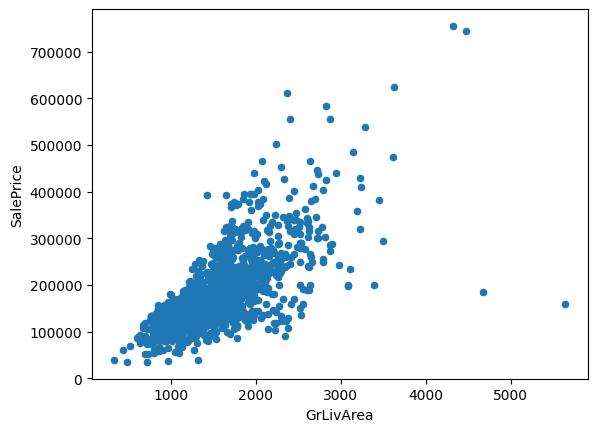

In [ ]:
data = pd.concat([y, X['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice')
plt.show()

There are two values with high GrLivArea that doesn't follow the trend. They can be deemed as outliers and hence we will remove those points. 

In [ ]:
# find the indices of the outliers
X.sort_values(by='GrLivArea', ascending=False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1298,1299,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,0,0,480,NA,NA,0,1,2008,New,Partial
523,524,60,RL,130.0,40094,Pave,NA,IR1,Bnk,AllPub,...,0,0,0,NA,NA,0,10,2007,New,Partial


In [ ]:
# drop the outliers
X = X.drop(X[X['Id']==1299].index)
X = X.drop(X[X['Id']==524].index)
y = np.append(y[:1298],y[1299:])
y = np.append(y[:523],y[524:])

In [ ]:
ntrain = ntrain-2

**Numerical -> Categorical**

In [ ]:
cols = ['MSSubClass','YrSold','MoSold']
for col in cols:
    X[col] = X[col].astype(str)

**New feature**: total areas

In [ ]:
X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + 0.5*X['HalfBath'] + X['BsmtFullBath'] + 0.5*X['BsmtHalfBath']
X['Has2ndfloor'] = X['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
X['TotalQual'] = X['OverallQual'] + X['OverallCond']

**Normality**
Since SalePrice is positively skewed, we will apply log transformation.

In [ ]:
# log transformation
y = np.log1p(y)

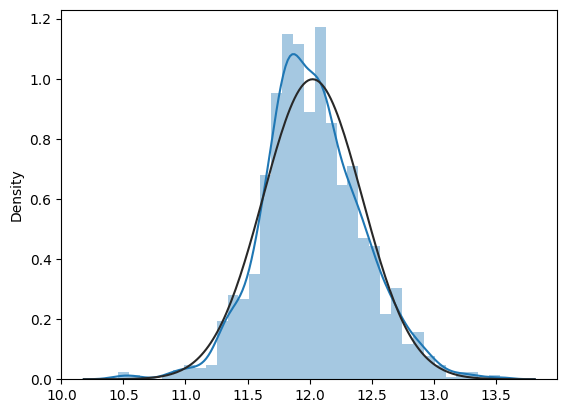

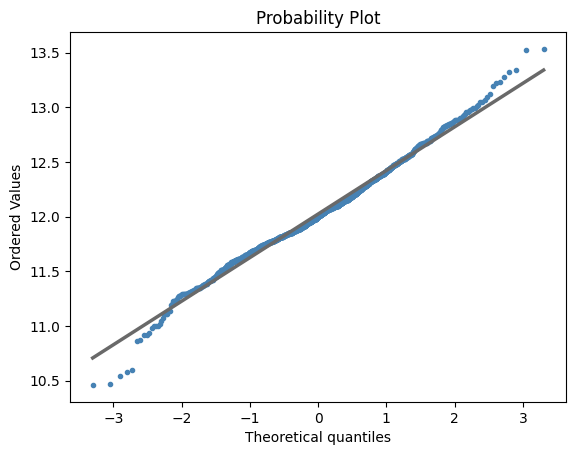

In [ ]:
# transformed histogram
sns.distplot(y, fit=norm)
fig = plt.figure()
ax = fig.add_subplot(111)
fig = stats.probplot(y, plot=plt)
ax.get_lines()[0].set_markerfacecolor('steelblue')
ax.get_lines()[0].set_markeredgecolor('steelblue')
ax.get_lines()[0].set_markersize(3)
ax.get_lines()[1].set_linewidth(2.5)
ax.get_lines()[1].set_color('dimgray')
plt.show()

**Other skewed features**

In [ ]:
# find skewed numerical features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        numeric.append(i)
        
skew_features = X[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 26 numerical features with skew > 0.5 :


MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
dtype: float64

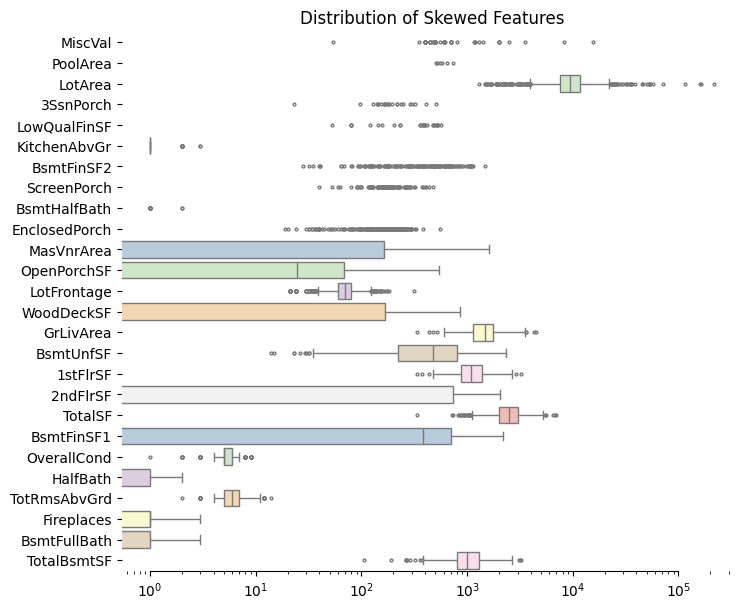

In [ ]:
# create box plots for highly skewed columns
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=X[skew_index], orient="h", palette="Pastel1", fliersize=2)
ax.xaxis.grid(False)
ax.set(title="Distribution of Skewed Features")
sns.despine(trim=True, left=True)

In [ ]:
# normalize skewed features
for col in skew_index:
    X[col] += 0.0001
    X[col], _ = stats.boxcox(X[col])

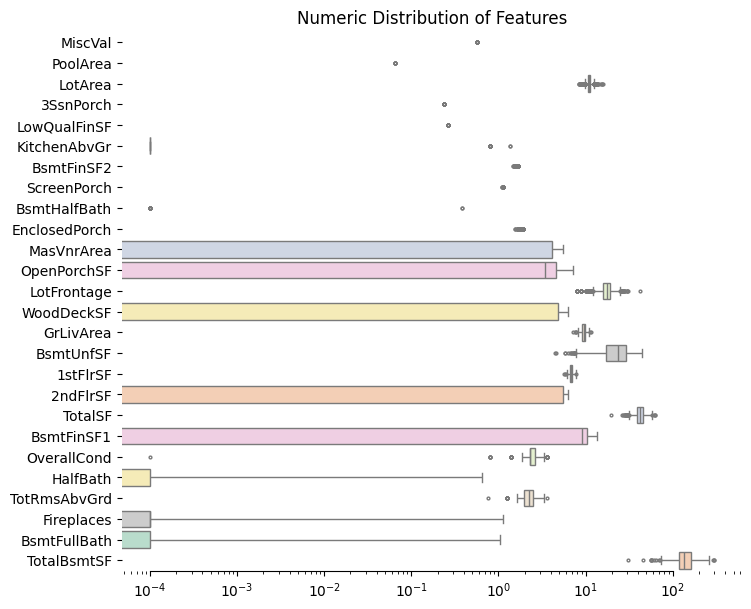

In [ ]:
# boxplots of normalized features
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=X[skew_index] , orient="h", palette="Pastel2", fliersize=2)
ax.xaxis.grid(False)
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

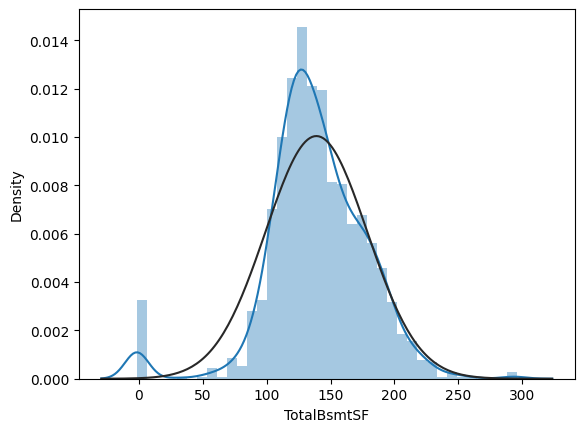

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.distplot(X['TotalBsmtSF'], fit=norm)
fig = plt.figure()

This column has positive skew and has many observations with value zero. To deal with this, we will create a new variable that indicates if the value is 0 or not (has basement or not), and then apply the log transformation to the non zero values. 

In [ ]:
# create a new column 
X['HasBsmt'] = pd.Series(len(X['TotalBsmtSF']), index=X.index)
X['HasBsmt'] = 0
X.loc[X['TotalBsmtSF']>0, 'HasBsmt'] = 1
# log transformation
X.loc[X['HasBsmt']==1, 'TotalBsmtSF']=np.log(X['TotalBsmtSF'])

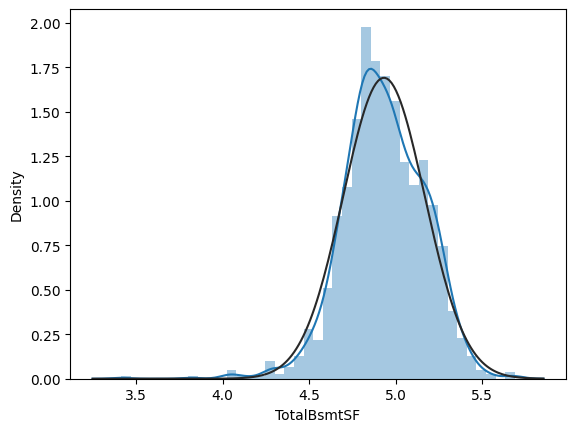

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.distplot(X[X['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm)
fig = plt.figure()

In [ ]:
X = pd.get_dummies(X)
X.shape

(1458, 429)

In [ ]:
data_id = X['Id']
X.drop(['Id'], axis=1, inplace=True)

In [119]:
X.shape, len(y)

((1458, 428), 1458)

# 3) Modelling

In [184]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

def grid_search(model, param_grid, cv, X, y):
    grid_search_model = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')
    grid_search_model.fit(X,y)
    best_params = grid_search_model.best_params_
    return best_params

In [185]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import xgboost as xgb

lasso_a = [0.0001, 0.0003, 0.0005, 0.0007, 0.0009]
elastic_a = [0.0001, 00.0003, 0.0005, 0.0007]

lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_a, random_state=42))
elasticNet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=elastic_a, l1_ratio=.9, random_state=42))
kernelRidge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.45, gamma=0.05, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state=42, nthread=-1)

**Base Models**

In [186]:
score = cv_rmse(lasso, X_train_scaled, y_train)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticNet, X_train_scaled, y_train)
print("Elastic Net score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(kernelRidge, X_train_scaled, y_train)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Lasso score: 0.1115 (0.0076)

Elastic Net score: 0.1113 (0.0080)

Kernel Ridge score: 0.1372 (0.0111)



In [187]:
score = cv_rmse(gbr, X_train_scaled, y_train)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1162 (0.0084)



In [188]:
score = cv_rmse(model_xgb, X_train_scaled, y_train)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1177 (0.0093)



**Stacked Model**

In [191]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index,:], y[train_index])
                y_pred = instance.predict(X[holdout_index,:])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
stacked_averaged_models = StackingAveragedModels(base_models = (elasticNet, gbr, kernelRidge),
                                                 meta_model = lasso)
stacked_averaged_models.fit(X_train_scaled, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train_scaled)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test_scaled))

In [193]:
score = cv_rmse(stacked_averaged_models,X_train_scaled, y_train)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1086 (0.0084)


In [197]:
print('RMSE of Stacked Model: {:.4f}'.format(np.sqrt(mean_squared_error(y_train, stacked_train_pred))))

RMSE of Stacked Model: 0.0803


**XGBoost Model**

In [199]:
model_xgb.fit(X_train_scaled, y_train)
xgb_train_pred = model_xgb.predict(X_train_scaled)
xgb_pred = np.expm1(model_xgb.predict(X_test_scaled))
print('RMSE of XGBoost Model: {:.4f}'.format(np.sqrt(mean_squared_error(y_train, xgb_train_pred))))

RMSE of XGBoost Model: 0.0880


In [ ]:
# ensemble prediction
ensemble = stacked_pred*0.70 + xgb_pred*0.3

In [229]:
import pickle

with open('stacked_model.pkl', 'wb') as file:
    pickle.dump(stacked_averaged_models, file)

with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)

In [223]:
X_test_scaled.iloc[0]

array([0.65676249, 0.47473616, 0.66666667, 0.53375373, 0.86821705,
       0.71186441, 0.        , 0.85673005, 0.        , 0.30575194,
       0.86754036, 0.53675939, 0.97822487, 0.        , 0.76127391,
       1.        , 0.        , 0.66666667, 0.9716264 , 0.5       ,
       0.64872588, 0.73594272, 0.87684879, 0.5       , 0.52759588,
       0.94397407, 0.83358523, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.67293816, 0.83333333, 1.        ,
       0.66666667, 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [228]:
with open('stacked_model.pkl', 'rb') as file:
    stacked_model = pickle.load(file)

np.expm1(stacked_model.predict(X_test_scaled[0].reshape(1, -1)))

array([324857.73242898])